<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/reviews/reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos Reviews

## 1) Introdução
Uma importante abordagem ao trabalhar com análise de dados de uma base comercial é justamente o feedback dos consumidores no que diz respeito à qualidade dos produtos, ao atendimento, etc. e a neste sentido é de suma importância ter uma base de dados que tenham essas informações, uma vez que elas ajudam a melhorar a qualidade do serviço.

Aqui não é diferente e neste notebook trabalharemos com uma base contendo, entre outros, os reviews dos clientes acerca dos produtos e uma nota atribuida a ele. Assim, utilizaremos alguns algorítmos de Processamento de Linguagem Natural (em inglês NPL) para fazer um classificador de sentimento, ou seja, determinar se um determinado review é positivo ou negativo.

Portanto, a partir da próxima seção iremos dar início a esta etapa do estudo.

## 2) Carregando e explorando os dados

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Carregando a base de dados
link = 'https://raw.githubusercontent.com/Mario-RJunior/olist-e-commerce/master/datasets/olist_order_reviews_dataset.csv'
reviews = pd.read_csv(link)

In [3]:
# Visualizando o cabeçalho
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# Verificando o shape do dataframe
reviews.shape

(100000, 7)

Devido ao tamanho muito grande do dataset, iremos pegar apenas uma amostra do mesmo afim de reduzir os custos computacionais, que neste caso é significativo.

Por conveniência, iremos considerar 40% dos dados originais.

In [5]:
# Gerando amostra do dataset
reviews_sample = reviews.sample(frac=0.4, random_state=2)

# Mostrando novo dataset
reviews_sample.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
6448,65e87641e147cd476cb45db794709d96,1e6eb05de9f71dd42f9ef81813dce355,5,NaN,Produto entregue antes do prazo. Serviço e pro...,2017-04-19 00:00:00,2017-04-19 21:39:51
50680,81cc7b52760844d20c4afeab2c71834c,934d3985d22709473850e6e644a19fea,5,NaN,NaN,2018-01-27 00:00:00,2018-01-30 13:14:50
814,397f27a0d2936d02d3447864e0398414,8f15948ef0bdb4709a5801084a564c56,3,NaN,"ótima compra\r\nmas o frete nao compensa,pesa ...",2017-10-20 00:00:00,2017-10-23 18:49:42
20354,5835427026f36ce691ad96313bddfe91,61b199f09f9de7776b875cce7c71e649,5,NaN,NaN,2018-05-04 00:00:00,2018-05-04 10:44:20
49224,7751f2853341c4c59f589164fc02898c,97c5a4acc0915c5bd17e5a3256693ef6,1,Produto veio com defeito,"Produto veio com defeito não funciona, bem vou...",2018-06-27 00:00:00,2018-06-29 19:39:14


In [6]:
# Visualizando o shape
reviews_sample.shape

(40000, 7)

In [7]:
# Retornando informações sobre o dataframe
reviews_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 6448 to 12739
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                40000 non-null  object
 1   order_id                 40000 non-null  object
 2   review_score             40000 non-null  int64 
 3   review_comment_title     4683 non-null   object
 4   review_comment_message   16551 non-null  object
 5   review_creation_date     40000 non-null  object
 6   review_answer_timestamp  40000 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


In [8]:
# Retornando algumas estatísticas
reviews_sample.describe()

,review_score
count,40000.000000
mean,4.076650
std,1.361533
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [9]:
# Verificando valores faltantes
reviews_sample.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       35317
review_comment_message     23449
review_creation_date           0
review_answer_timestamp        0
dtype: int64

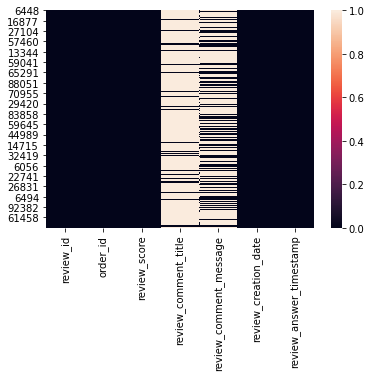

In [10]:
# Visualizando valores faltantes com heatmap
sns.heatmap(data=reviews_sample.isnull());

Confirmamos que há uma grande quantidade de valores faltantes.

In [11]:
# Visualizando alguns comentários
reviews_sample['review_comment_message']

6448     Produto entregue antes do prazo. Serviço e pro...
50680                                                  NaN
814      ótima compra\r\nmas o frete nao compensa,pesa ...
20354                                                  NaN
49224    Produto veio com defeito não funciona, bem vou...
                               ...                        
34197    Já paguei faz tempo, estou precisando é ainda ...
57789                                                  NaN
96663    Entrega recebida bem antestreia do prazo estab...
92710      Ainda não usei o produto mas tudo foi certinho 
12739                                                  NaN
Name: review_comment_message, Length: 40000, dtype: object

In [12]:
# Visualizando alguns títulos dos comentários
reviews_sample['review_comment_title'].unique()

array([nan, 'Produto veio com defeito', 'Super recomendo', ...,
       'Rápido e eficiente', 'Produto entregue em parte',
       'Produto diferente '], dtype=object)

In [13]:
# Número de títulos não únicos
reviews_sample['review_comment_title'].nunique()

2129

In [14]:
# Contagem dos scores
reviews_sample['review_score'].value_counts()

5    23150
4     7565
1     4776
3     3262
2     1247
Name: review_score, dtype: int64

Podemos ainda fazer um histograma para verificar a ocorrência dos scores.

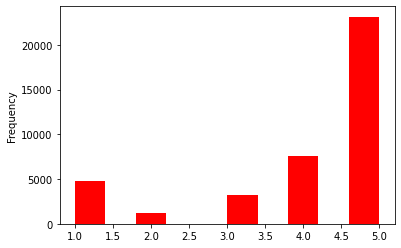

In [15]:
# # Plotando histograma
reviews_sample['review_score'].plot(kind='hist', color='r');

### Adicionando coluna para classificação

No dataframe reviews temos a coluna "review_score" que representa as notas (de 1 a 5) para os serviços oferecidos. Neste caso, como queremos criar um classificador binário para os comentários (positivos e negativos) devemos então gerar esta classificação baseado no score dado para cada comentário. Assim, tomaremos o seguinte critério:

- scores 1, 2 e 3: comentário negativo = 0;
- scores 4 e 5: comentário positivo = 1.

Desta forma, adicionaremos a coluna "feedback" com a respectiva classificação para cada comentário.

In [16]:
# Adicionando a coluna "feedback"
reviews_sample['feedback'] = reviews_sample['review_score'].apply(lambda x: 1 if x >= 4 else 0)

In [17]:
# Verificando o dataframe com a nova coluna
reviews_sample

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,feedback
6448,65e87641e147cd476cb45db794709d96,1e6eb05de9f71dd42f9ef81813dce355,5,NaN,Produto entregue antes do prazo. Serviço e pro...,2017-04-19 00:00:00,2017-04-19 21:39:51,1
50680,81cc7b52760844d20c4afeab2c71834c,934d3985d22709473850e6e644a19fea,5,NaN,NaN,2018-01-27 00:00:00,2018-01-30 13:14:50,1
814,397f27a0d2936d02d3447864e0398414,8f15948ef0bdb4709a5801084a564c56,3,NaN,"ótima compra\r\nmas o frete nao compensa,pesa ...",2017-10-20 00:00:00,2017-10-23 18:49:42,0
20354,5835427026f36ce691ad96313bddfe91,61b199f09f9de7776b875cce7c71e649,5,NaN,NaN,2018-05-04 00:00:00,2018-05-04 10:44:20,1
49224,7751f2853341c4c59f589164fc02898c,97c5a4acc0915c5bd17e5a3256693ef6,1,Produto veio com defeito,"Produto veio com defeito não funciona, bem vou...",2018-06-27 00:00:00,2018-06-29 19:39:14,0
...,...,...,...,...,...,...,...,...
34197,ae0c4bea81f7dda866bd1ba12d235213,39d0bd05538b0d573193744390e86223,1,NaN,"Já paguei faz tempo, estou precisando é ainda ...",2018-03-24 00:00:00,2018-03-24 11:04:49,0
57789,c4e29cfc5265e1b2200f063ab60405a7,cecc450aed233004e69538a4ce7f7f37,5,NaN,NaN,2017-05-27 00:00:00,2017-05-30 10:46:00,1
96663,3be4d9828f24b3567084677feff43908,865301eccebb37c03ad8ccd1cb994b2b,5,NaN,Entrega recebida bem antestreia do prazo estab...,2018-04-19 00:00:00,2018-04-21 22:37:50,1
92710,a5e4ad45d1d943c92d14fd0193e8d752,35580ca9f2a84299b3b6c41875ba71a7,5,NaN,Ainda não usei o produto mas tudo foi certinho,2018-04-07 00:00:00,2018-04-08 01:03:13,1


Agora precisamos eliminar as colunas do dataframe que não serão utilizadas. Logo, deixaremos apenas as colunas "review_comment_message" e "feedback".

In [18]:
# Deletando colunas desnecessárias
reviews_sample = reviews_sample.drop(columns=['review_id', 'order_id', 'review_score', 
                                'review_comment_title', 'review_creation_date',	
                                'review_answer_timestamp'], axis=1)

# Deletando registros com valores faltantes
reviews_sample.dropna(inplace=True)

# Reindexando os registros
reviews_sample = reviews_sample.reset_index()

# Removendo a coluna index
reviews_sample.drop(columns='index', inplace=True, axis=1)

# Visualizando o cabeçalho
reviews_sample.head()

,review_comment_message,feedback
0,Produto entregue antes do prazo. Serviço e pro...,1
1,"ótima compra\r\nmas o frete nao compensa,pesa ...",0
2,"Produto veio com defeito não funciona, bem vou...",0
3,satisfeita com a compra realizada.,1
4,OBRIGADA PELO ATENDIMENTO!,1


In [19]:
# Visualizando o novo shape do dataframe
reviews_sample.shape

(16551, 2)

Podemos confirmar que o novo dataframe não tem valores faltantes pelo heatmap.

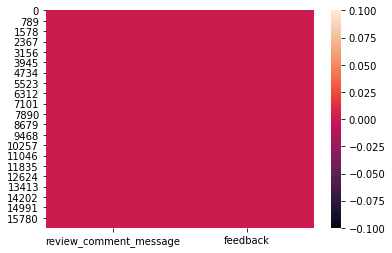

In [20]:
# Heatmap
sns.heatmap(data=reviews_sample.isnull());

In [21]:
reviews_sample.isnull().sum()

review_comment_message    0
feedback                  0
dtype: int64

Podemos plotar um histograma da coluna "feedback".

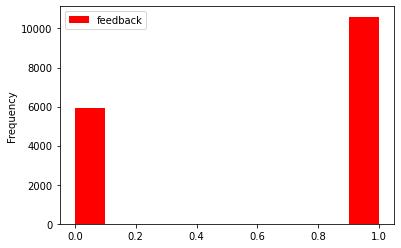

In [22]:
reviews_sample.plot(kind='hist', color='r');

Podemos ainda adicionar mais uma estatística para entendermos melhor os nossos dados. Neste caso, iremos verificar qual é, em média, o número de caracteres de cada comentário. Criaremos então, outro dataframe para este fim.

In [23]:
# Criação do novo dataframe
reviews_character_length = reviews_sample.copy() 

# Criando a coluna com o número de caracteres
reviews_character_length['length'] = reviews_sample['review_comment_message'].apply(len)

In [24]:
# Visualizando o cabeçalho
reviews_character_length

,review_comment_message,feedback,length
0,Produto entregue antes do prazo. Serviço e pro...,1,78
1,"ótima compra\r\nmas o frete nao compensa,pesa ...",0,83
2,"Produto veio com defeito não funciona, bem vou...",0,137
3,satisfeita com a compra realizada.,1,34
4,OBRIGADA PELO ATENDIMENTO!,1,26
...,...,...,...
16546,"Eu não recebi o xale do sofá, porém ao ligar, ...",0,67
16547,Amei!\r\nSão lindos e de ótima qualidade!,1,39
16548,"Já paguei faz tempo, estou precisando é ainda ...",0,69
16549,Entrega recebida bem antestreia do prazo estab...,1,53


In [25]:
# Estatísticas de reviews_character_length
reviews_character_length.describe()

,feedback,length
count,16551.000000,16551.000000
mean,0.640445,70.568244
std,0.479885,55.347758
min,0.000000,1.000000
25%,0.000000,29.000000
50%,1.000000,54.000000
75%,1.000000,98.000000
max,1.000000,204.000000


In [26]:
# Checando alguns reviews
reviews_character_length.query('length == 1')

,review_comment_message,feedback,length
125,.,1,1
292,.,1,1
557,.,1,1
756,S,0,1
956,s,1,1
1811,I,1,1
2114,.,1,1
2437,.,1,1
2508,s,1,1
2566,.,0,1


In [27]:
# Verificando a quantidade de caracteres únicos
reviews_character_length.query('length == 1')['review_comment_message'].value_counts()

.    23
-     3
*     2
o     2
5     2
s     2
😀     1
I     1
X     1
m     1
?     1
Y     1
A     1
S     1
👍     1
O     1
Name: review_comment_message, dtype: int64

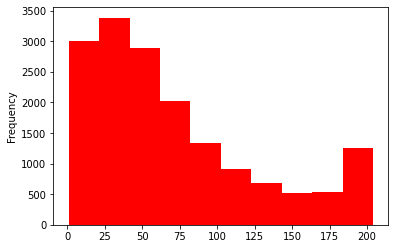

In [28]:
# Histograma para o tamanho dos reviews
reviews_character_length['length'].plot(kind='hist', color='r');

### Reviews positivos e negativos

Iremos agora gerar dataframes com reviews positivos e negativos e comparar ambos.

In [29]:
# Dataframe negativo
negative = reviews_character_length.query('feedback == 0')
negative.head()

,review_comment_message,feedback,length
1,"ótima compra\r\nmas o frete nao compensa,pesa ...",0,83
2,"Produto veio com defeito não funciona, bem vou...",0,137
5,"No site consta como entregue, porém NÃO recebi...",0,52
6,Comprei como srmpre faço. Porém dessa vez o pr...,0,131
7,O produto não foi entregue. Nem se quer chegou...,0,56


In [30]:
# Shape
negative.shape

(5951, 3)

In [31]:
# Visualizando estatística
negative.describe()

,feedback,length
count,5951.0,5951.000000
mean,0.0,98.157957
std,0.0,61.112536
min,0.0,1.000000
25%,0.0,46.000000
50%,0.0,87.000000
75%,0.0,151.000000
max,0.0,204.000000


In [32]:
# Dataframe positivo
positive = reviews_character_length.query('feedback == 1')
positive.head()

,review_comment_message,feedback,length
0,Produto entregue antes do prazo. Serviço e pro...,1,78
3,satisfeita com a compra realizada.,1,34
4,OBRIGADA PELO ATENDIMENTO!,1,26
8,"Atendimento especial,adorei comprar nas lojas ...",1,139
9,Muito bom,1,9


In [33]:
# Shape
positive.shape

(10600, 3)

In [34]:
# Visualizando estatística
positive.describe()

,feedback,length
count,10600.0,10600.000000
mean,1.0,55.078962
std,0.0,44.938285
min,1.0,1.000000
25%,1.0,23.000000
50%,1.0,43.000000
75%,1.0,73.000000
max,1.0,204.000000


Vemos que os comentários negativos é, em média, maior do que os positivos e um motivo plausível é a possibilidade de as pessoas com queixas do serviço explicarem mais detalhadamente sua insatisfação.

### Nuvem de palavras

Agora, criaremos duas nuvens de palavra para cada dataframe (positivo e negativo) para entendermos quais palavras mais se destacam em ambos os casos. Para isso, devemos colocar todos os reviews como se fosse uma string apenas. Então, temos o seguinte código com este propósito.

- Reviews positivos

In [35]:
# Colocando reviews positivos em uma lista
positive_reviews = positive['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
positive_reviews[0:5]

['Produto entregue antes do prazo. Serviço e produto 100% atendidos. Parabéns!!!',
 'satisfeita com a compra realizada.',
 'OBRIGADA PELO ATENDIMENTO!',
 'Atendimento especial,adorei comprar nas lojas lannister pelo site o produto veio correto.Parabéns pelo desempenho.Sou um cliente satisfeito',
 'Muito bom']

In [36]:
# Juntando em apenas uma string
sentence_as_one_string = ' '.join(positive_reviews)

Gerando a nuvem de palavras.

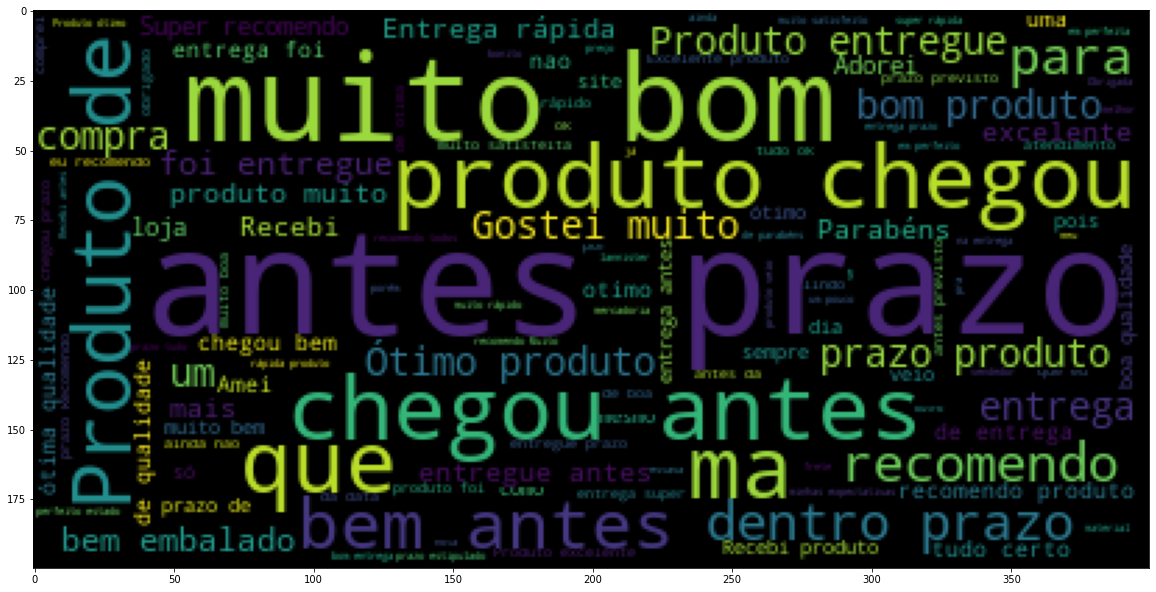

In [37]:
# Importando a biblioteca
from wordcloud import WordCloud

# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentence_as_one_string));

- Reviews negativos

In [38]:
# Colocando reviews negativos em uma lista
negative_reviews = negative['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
negative_reviews[0:5]

['ótima compra\r\nmas o frete nao compensa,pesa no orçamento.\r\ndevia ter frete grates\r\n',
 'Produto veio com defeito não funciona, bem vou pedir troca, o preço não vale a dor de cabeça, fui em uma elétrica e comprei um prestasse.',
 'No site consta como entregue, porém NÃO recebi nada.',
 'Comprei como srmpre faço. Porém dessa vez o produto ficou retido no correio de outro município e não entre em casa como de costume.',
 'O produto não foi entregue. Nem se quer chegou em casa. ']

In [39]:
# Juntando em apenas uma string
negative_sentence_as_one_string = ' '.join(negative_reviews)

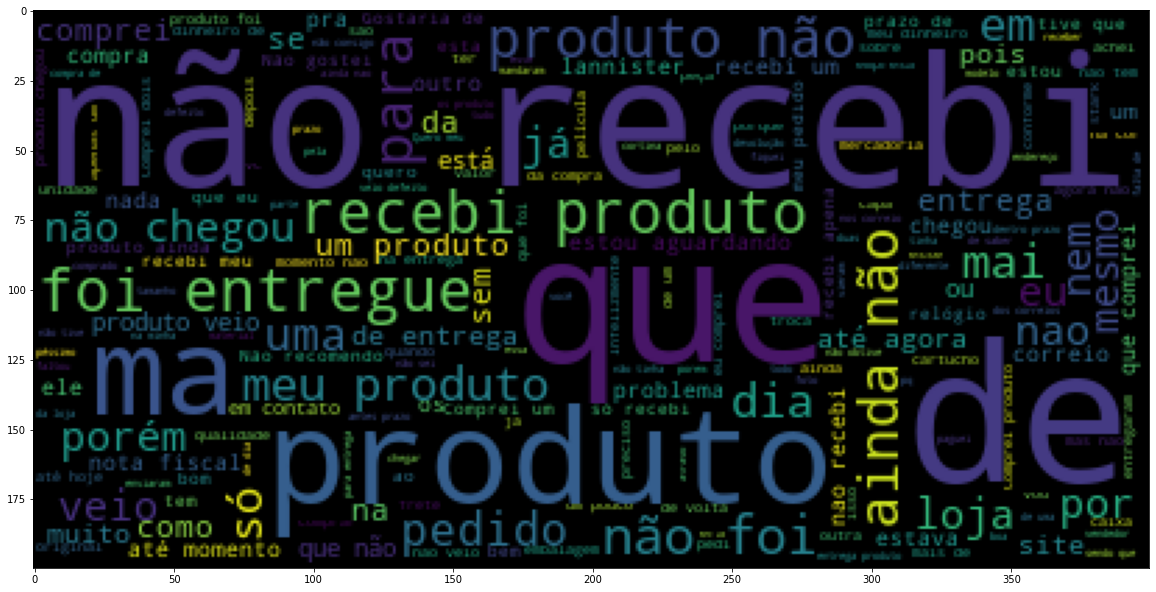

In [40]:
# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(negative_sentence_as_one_string));

## Remoção de pontuação

Para criar o modelo preditivo de sentimento precisamos tratar os dados (da coluna reviews) e o tratamento neste caso consiste na remoção de pontuação e das chamadas "stop words". Inicialmente iremos tratar a pontuação para, na próxima seção, tratar as stop words.

In [41]:
# Importando a bibliotecas
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Podemos fazer um teste com um review para termos certeza que o código servirá para nosso propósito.

In [42]:
# Selecionando um review qualquer do dataframe
test = reviews_sample['review_comment_message'].iloc[200]
test

'No prazo, como sempre!!!!!!!'

In [43]:
test_punct = [letra for letra in test if letra not in string.punctuation]
print(test_punct)

['N', 'o', ' ', 'p', 'r', 'a', 'z', 'o', ' ', 'c', 'o', 'm', 'o', ' ', 's', 'e', 'm', 'p', 'r', 'e']


Note que removemos a pontuação do review original. Agora, podemos juntá-lo novamente em uma frase sem tais pontuações.

In [44]:
# Juntando novamente a frase
test_punct = ''.join(test_punct)
print(test_punct)

No prazo como sempre


## Remoção de stop words

Agora iremos remover as stop words, ou seja, aquelas palavras que não contruibuem para o significado positivou ou negativo dos reviews.

In [45]:
# Importando a biblioteca
import nltk

In [46]:
# Fazendo download de alguns pacotes
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Como os textos estão em português, precisamos baixar as stop words no mesmo idioma e para isso importaremos uma biblioteca específica do pacote ***nltk***.

In [47]:
# Importando bibliotecas
from nltk.corpus import stopwords

# Stop words em português
print(stopwords.words('portuguese'))


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [48]:
# Verificando a quantidade de stop words
len(stopwords.words('portuguese'))

204

Podemos agora testar a remoção de stop words para o review de teste que criamos acima.

In [49]:
# Removendo stopwords do review de teste
test_punct = [word for word in test_punct.split() if word.lower() not in stopwords.words('portuguese')]

In [50]:
# Verificando o resultado
test_punct

['prazo', 'sempre']

## Count vectorization (tokenização)

Nesta seção faremos o processo de tokeniação, ou seja, iremos converter cada palavras em números e fazer uma contagem de cada uma delas para verifica sua ocorrência em uma frase.

In [51]:
# Importando a biblioteca
from sklearn.feature_extraction.text import CountVectorizer

Ulitilizando a frase de testes acima para verificação.

In [52]:
# Criando um objeto para vetorização
vectorizer = CountVectorizer()

# Aplicando à frase de testes
x = vectorizer.fit_transform(test_punct)

In [53]:
# Verificando o resultado
x

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [54]:
# Verificando as palavras vetorizadas
vectorizer.get_feature_names()

['prazo', 'sempre']

In [55]:
# Visualizando a matriz resultante
x.toarray()

array([[1, 0],
       [0, 1]])

## Pipeline para limpeza de dados

Agora sim iremos aplicar os códigos escritos acima para toda a base de dados.

In [56]:
# Criando a função
def message_cleaning(message):
  # text = re.sub(r'\.+', ' ', message)
  text = [char for char in message if char not in string.punctuation]
  text = ''.join(text)
  text = [word for word in text.split() if word.lower() not in stopwords.words('portuguese')]
  return text

In [57]:
# Aplicando a função no dataframe
reviews_df_clean = reviews_sample['review_comment_message'].apply(message_cleaning)

In [58]:
# Visualizando o dataframe
reviews_df_clean

0        [Produto, entregue, antes, prazo, Serviço, pro...
1        [ótima, compra, frete, nao, compensapesa, orça...
2        [Produto, veio, defeito, funciona, bem, vou, p...
3                          [satisfeita, compra, realizada]
4                                  [OBRIGADA, ATENDIMENTO]
                               ...                        
16546    [recebi, xale, sofá, porém, ligar, consta, rec...
16547                     [Amei, lindos, ótima, qualidade]
16548    [paguei, faz, tempo, precisando, ainda, recebi...
16549    [Entrega, recebida, bem, antestreia, prazo, es...
16550               [Ainda, usei, produto, tudo, certinho]
Name: review_comment_message, Length: 16551, dtype: object

In [59]:
# Fazendo a vectorização
vectorizer = CountVectorizer(analyzer=message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(reviews_sample['review_comment_message'])

In [60]:
# Vendo as palavras únicas
print(vectorizer.get_feature_names())

['0', '00', '000000000000000000000000000', '000024453', '001689', '003566', '003570', '01', '01032018', '0106', '01062017', '0109', '010918', '01092017', '01122017', '012495', '0162017', '0163750232', '0163751255', '0164784672', '0165096389', '0165465041', '0166709005', '0166821151neste', '0168759427', '01um', '02', '0201', '020218', '02032018', '020617', '02082018', '02645364747', '02649450934', '02653047820', '02654859320', '02655871733', '02657469076', '02657530904', '02658697704', '02664287063', '02666377620', '03', '03012018', '03022018', '0303', '03032018', '0304', '03042017', '0305', '0307', '031117', '03497913106', '04', '0401', '0404', '0405', '04102016', '041217', '05', '0501', '05022018', '0503', '0504', '050717', '05092017', '0511', '05ml', '06', '060118', '06022018', '0603', '0604', '06042018', '0606', '060618', '06062018', '06072018', '0608', '060818', '06082018', '060cm', '0612', '062018', '07', '0702', '0705', '07052018Só', '0706', '07092018', '0712', '071217', '0712201

In [61]:
# Contagem de palavras únicas
len(vectorizer.get_feature_names())

13858

In [62]:
# Visualizando shape
reviews_countvectorizer.shape

(16551, 13858)

Temos que gerar um dataframe final contendo os dados de reviews_coutvectorizer e a coluna "feedback". Para isso ocorrer, seguiremos os seguintes passos

1) Deletaremos a coluna "review_comment_message" do dataframe reviews_sample.

2) Criaremos um dataframe com os valores de "reviews_countvectorizer".

3) Concatenaremos reviews_sample com o dataframe criado no passo 2.

In [63]:
# Deletando a coluna "review_comment_message" 
reviews_sample.drop(columns='review_comment_message', axis=1, inplace=True)

# Criando dataframe para valores tokenizados
countvectorizer_df = pd.DataFrame(reviews_countvectorizer.toarray())

# Concatenando os dataframes acime
reviews_sample = pd.concat([reviews_sample, countvectorizer_df], axis=1)

In [64]:
# Visualizando o dataframe final dos reviews
reviews_sample

,feedback,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,13818,13819,13820,13821,13822,13823,13824,13825,13826,13827,13828,13829,13830,13831,13832,13833,13834,13835,13836,13837,13838,13839,13840,13841,13842,13843,13844,13845,13846,13847,13848,13849,13850,13851,13852,13853,13854,13855,13856,13857
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16547,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16549,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Criação do modelo preditivo

Por fim, queremos criar um modelo que preveja se um determinado comentário é positivo ou negativo. Para tal, iremos dividir a base acime entre previsores (X) e classe (y).

In [85]:
# Dividindo o dataframe
X = reviews_sample.drop(columns='feedback', axis=1)
y = reviews_sample['feedback']

In [87]:
# Visualizando X
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,13818,13819,13820,13821,13822,13823,13824,13825,13826,13827,13828,13829,13830,13831,13832,13833,13834,13835,13836,13837,13838,13839,13840,13841,13842,13843,13844,13845,13846,13847,13848,13849,13850,13851,13852,13853,13854,13855,13856,13857
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
# Visualizando y
y

0        1
1        0
2        0
3        1
4        1
        ..
16546    0
16547    1
16548    0
16549    1
16550    1
Name: feedback, Length: 16551, dtype: int64

### Treinamento e avaliação com Naive Baiyes

Faremos agora a criação de fato do modelo utilizando o algorítmo Naive Bayes. Mas antes iremos separar a base X entre base de treino e de teste.